<a href="https://colab.research.google.com/github/Krisss993/GAN/blob/main/06_13_GAN_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loss function:
Earth movel distance - The effort needed to make both distributions equal
- Critics(discriminator) values not restricted to be between 0 and 1
- Even for very different distributions, gradients are significant and high enough to drive the process in the right way

In [1]:
import torch
import torchvision
import os
import PIL
import pdb
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
from PIL import Image

In [2]:
# OPTIONAL
!pip install wandb -qqq
import wandb
wandb.login(key='9e59c0e5f929ee5a223fead436cba53be4f90e1a')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.7 MB/s eta 0:00:00


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
def show(tensor, num=25, wandbactivation=0, name=''):
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=5).permute(1,2,0)

  # optional
  # wandb - online activation
  if (wandbactivation==1 and wandbact==1):
      wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})


  # cliping pixels to range(0,1)
  plt.imshow(grid.clip(0,1))
  plt.show()


In [5]:
## hyperparameters and general parameters

n_epochs = 1000
batch_size = 128
lr = 1e-4

# z_dim - input noise latent vector dim
z_dim = 200
device = 'cuda'

cur_step = 0

# 5 cycles training of the critic, then 1 of the generator
# generally critic needs more training than the generator
crit_cycles = 5

gen_losses = []
crit_losses = []
show_step  = 35
save_step = 35

# optional, tracking stats online
wandbact = 1


In [6]:
# optional wandb
%%capture
# experiment_name = wandb.util.generate_id()
experiment_name = 'MY EXP'
myrun = wandb.init(
    project='wgan',
    name=experiment_name,
    group=experiment_name,
    config={'optimizer':'adam',
            'model':'wgan gp',
            'epoch':'1000',
            'batch_size':128
            }
)
config = wandb.config

In [7]:
# optional wandb
print(experiment_name)

MY EXP


In [34]:
# generator model

class Generator(nn.Module):

  # d_dim - internal dimension for the output of the convolutional layers
  def __init__(self, z_dim=64, d_dim=16):
    super(Generator, self).__init__()
    self.z_dim = z_dim

    self.gen = nn.Sequential(

        # ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding=0
        # n - width or height
        # (n - 1) * stride - 2 * padding + kernel_size

        # generator starts 1x1 pixel and z_dim number of channels and it gives it dimensionality of latent space
        # starting with 200 channels bringing up channels to 512 and increasing size of the image

        # 1st block
        nn.ConvTranspose2d(in_channels=z_dim, out_channels=d_dim*32, kernel_size=4, stride=1, padding=0),
        # normalizing values for improving stability, num_features = out from conv layer
        nn.BatchNorm2d(num_features=d_dim*32),
        # applying nonlinearity
        nn.ReLU(True),


        # 2nd block
        nn.ConvTranspose2d(in_channels=d_dim*32, out_channels=d_dim*16, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(d_dim*16),
        nn.ReLU(inplace=True),

        # 3rd block
        nn.ConvTranspose2d(in_channels=d_dim*16, out_channels=d_dim*8, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(d_dim*8),
        nn.ReLU(inplace=True),

        # 4th block
        nn.ConvTranspose2d(in_channels=d_dim*8, out_channels=d_dim*4, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(d_dim*4),
        nn.ReLU(inplace=True),

        # 5th block
        nn.ConvTranspose2d(in_channels=d_dim*4, out_channels=d_dim*2, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(d_dim*2),
        nn.ReLU(inplace=True),

        # 6th block
        # in output layer we stay with ONLY 3 channels
        nn.ConvTranspose2d(in_channels=d_dim*2, out_channels=d_dim*1, kernel_size=4, stride=2, padding=1),
        # no batch norm

        # result from -1 to 1
        nn.Tanh()

    )


  def forward(self, noise):
    # generator recives noise as input
    x = noise.view(len(noise), self.z_dim, 1, 1) # 128(batch) x 200(z_dim) x 1(height) x 1(width)

    return self.gen(x)


  def gen_noise(num, z_dim, device='cuda'):
    return torch.randn(num, z_dim, device=device) # 128 x 200


# n - width or height
# nn.Conv2d: (n + 2 * pad - ks) // stride + 1
# nn.ConvTranspose2d: (n - 1) * stride - 2 * padding + kernel_size

(n - 1) * stride - 2 * padding + kernel_size
- 1st step:
- (1 - 1) * 1 - 2 * 0 + 4 = 4x4 image, channels: 200 to 512
- 2nd step
- (4 - 1) * 2 - 2 * 1 + 4 = 8x8 image, channels: 512 to 256
- 3rd step
- (8 - 1) * 2 - 2 * 1 + 4 = 16x16 image, channels: 256 to 128
- 4th step
- (16 - 1) * 2 - 2 * 1 + 4 = 32x32 image, channels: 128 to 64
- 5th step
- (32 - 1) * 2 - 2 * 1 + 4 = 64x64 image, channels: 64 to 32
- 6th step
- (64 - 1) * 2 - 2 * 1 + 4 = 128x128 image, channels: 32 to 3

In [10]:
# critic model
# Conv2d: in_channels, out_channels, kernel_size, stride=1, padding=0
# (n + 2 * padding - kernel_size) // stride + 1

class Critic(nn.Module):
  def __init__(self, d_dim=16):
    super(Critic, self).__init__()

    self.crit = nn.Sequential(
        # 1st block
        nn.Conv2d(in_channels=3, out_channels=d_dim, kernel_size=4, stride=2, padding=1),

        # instead of batchnorm2d, normalizing according to the values of the whole instance insted of values of the batch
        nn.InstanceNorm2d(d_dim), # works the best

        # leaky keeps information, negative values have little slope(small negative numbers), but theyre not converted to 0
        nn.LeakyReLU(0.2),

        # 2nd block
        nn.Conv2d(in_channels=d_dim, out_channels=d_dim*2, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(d_dim*2),
        nn.LeakyReLU(0.2),

        # 3rd block
        nn.Conv2d(in_channels=d_dim*2, out_channels=d_dim*4, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(d_dim*4),
        nn.LeakyReLU(0.2),

        # 4th block
        nn.Conv2d(in_channels=d_dim*4, out_channels=d_dim*8, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(d_dim*8),
        nn.LeakyReLU(0.2),

        # 5th block
        nn.Conv2d(in_channels=d_dim*8, out_channels=d_dim*16, kernel_size=4, stride=2, padding=1),
        nn.InstanceNorm2d(d_dim*16),
        nn.LeakyReLU(0.2),

        # 6th block
        # we return 1 value, either its fake or real
        # stride has to be 1 and padding 0
        nn.Conv2d(in_channels=d_dim*16, out_channels=1, kernel_size=4, stride=1, padding=0),

    )


  def forward(self, image):
    # image: 128(batch) x 3(channels) x 128(height) x 128(width)
    crit_pred = self.crit(image) # 128 x 1 x 1 x 1
    return crit_pred.view(len(crit_pred), -1) # 128(batch values) x 1(fake or real)


(n + 2 * padding - kernel_size) // stride + 1
- 1st step
- (128 + 2 * 1 - 4) //2 + 1 = 64x64 image, channels: 3 to 16
- 2nd step
- (64 + 2 * 1 - 4) //2 + 1 = 32x32 image, channels: 16 to 32
- 3rd step
- (32 + 2 * 1 - 4) //2 + 1 = 16x16 image, channels: 32 to 64
- 4th step
- (16 + 2 * 1 - 4) //2 + 1 = 8x8 image, channels: 64 to 128
- 5th step
- (8 + 2 * 1 - 4) //2 + 1 = 4x4 image, channels: 128 to 256
- 6th step
- (4 + 2 * 0 - 4) //1 + 1 = 1x1 image, channels: 256 to 1

Alternative way to initialize parameters


In [11]:
def init_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal(m.weight, 0.0, 0.02)
    torch.nn.init.constant(m.bias, 0)

  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal(m.weight, 0.0, 0.02)
    torch.nn.init.constant(m.bias, 0)

# Initializations - NOT HERE
# gen = gen.apply(init_weights)
# crit = crit.apply(init_weights)

In [28]:
# loading dataset
import gdown, zipfile

# url = ''
path = '/content/drive/MyDrive'
download_path = f'{path}/img_align_celeba.zip'

if not os.path.exists(path):
  os.makedirs(path)

# gdown.download(url, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall('.')

In [19]:
!wget https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?resourcekey=0-dYn9z10tMJOBAkviAcfdyQ
!unzip -q img_align_celeba.zip

--2024-06-17 10:52:45--  https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view?resourcekey=0-dYn9z10tMJOBAkviAcfdyQ
Resolving drive.google.com (drive.google.com)... 108.177.121.138, 108.177.121.100, 108.177.121.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.121.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?resourcekey=0-dYn9z10tMJOBAkviAcfdyQ’

view?resourcekey=0-     [ <=>                ]  88.03K  --.-KB/s    in 0.003s  

2024-06-17 10:52:45 (26.0 MB/s) - ‘view?resourcekey=0-dYn9z10tMJOBAkviAcfdyQ’ saved [90138]

unzip:  cannot find or open img_align_celeba.zip, img_align_celeba.zip.zip or img_align_celeba.zip.ZIP.


In [31]:
# class Dataset(Dataset):
class Dataset():
  def __init__(self, path, size=128, lim=10000):
    self.sizes = [size, size]

    # paths to the images
    items, labels = [], []

    for data in os.listdir(path)[:lim]:
      # path: './data/celeba/img_align_celeba'
      # data: '123213.img'
      item = os.path.join(path, data)
      items.append(item)
      labels.append(data)
    self.items=items
    self.labels=labels

  def __len__(self):
    return len(self.items)

  def __getitem__(self, idx):
    # open image idx
    data = PIL.Image.open(self.items[idx]).convert('RGB') # size of the image: fe. 1278, 121
    data = np.asarray(torchvision.transforms.Resize(self.sizes)(data)) # 128 x 128 x 3
    data = np.transpose(data, (2,0,1)).astype(np.float32, copy=False) # 3 x 128 x 128
    # from np to tensor for training, div = standarizing
    data = torch.from_numpy(data).div(255) # leaving values from 0 to 1
    return data, self.labels[idx]


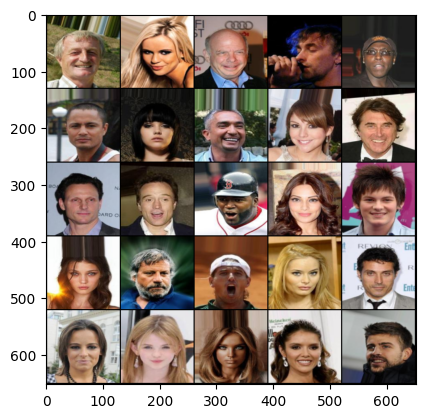

In [37]:
# Dataset
data_path = './img_align_celeba'
ds = Dataset(data_path, size=128, lim=10000)

# DataLoader
dataloader = DataLoader(dataset=ds, batch_size=128, shuffle=True)

# Models
gen = Generator(z_dim=z_dim).to(device)
crit = Critic().to(device)

# Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9)) # betas - internal calculations, works well with this architecture
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5, 0.9))

# Initializations - OPTIONAL
gen = gen.apply(init_weights)
crit = crit.apply(init_weights)

# wandb - OPTIONAL
if (wandbact==1):
  wandb.watch(gen, log_freq=100)
  wandb.watch(crit, log_freq=100)

x, y = next(iter(dataloader))
show(x)